# Imports

In [1]:
import time

import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

from src.constants import CNN_TRAIN_IMAGES_PATH, CNN_VALIDATION_IMAGES_PATH, MODEL_PATH
import matplotlib.pyplot as plt

# Constants

In [2]:
INIT_LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 10

# Initializations

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainImages = ImageFolder(CNN_TRAIN_IMAGES_PATH, transform=transform)
valImages = ImageFolder(CNN_VALIDATION_IMAGES_PATH, transform=transform)
trainDataLoader = DataLoader(trainImages, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valImages, batch_size=BATCH_SIZE)

# Visualizing the data

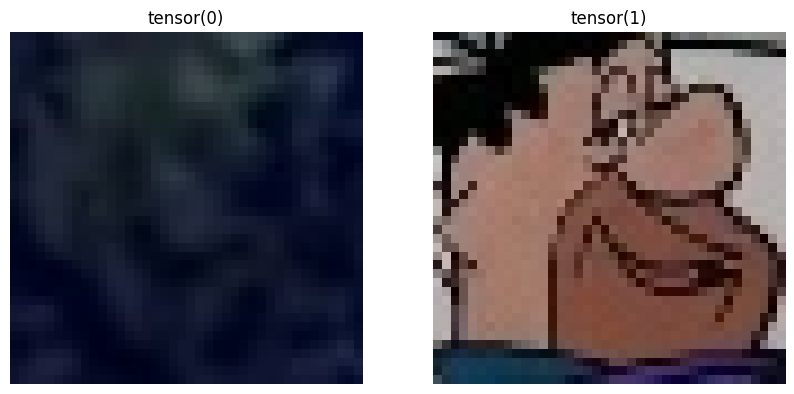

In [5]:
plot = plt.figure(figsize=(10, 10))
positive_found = False
negative_found = False

for x, y in trainDataLoader:
    for i in range(BATCH_SIZE):
        if y[i] == 0 and not negative_found:
            negative_found = True
            plot.add_subplot(1, 2, 1)
            plt.imshow(x[i].permute(1, 2, 0))
            plt.title(y[i])
            plt.axis("off")
        elif y[i] == 1 and not positive_found:
            positive_found = True
            plot.add_subplot(1, 2, 2)
            plt.imshow(x[i].permute(1, 2, 0))
            plt.title(y[i])
            plt.axis("off")
    break

# Model

In [6]:
model = Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.25),
    nn.Linear(2 * 2 * 128, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 1),
    nn.Sigmoid(),
).to(device)

# Optimizer and loss function

In [7]:
optimizer = Adam(model.parameters(), lr=INIT_LR)
loss_function = nn.BCEWithLogitsLoss()

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

# Training

In [8]:
print("[INFO] training the network...")
startTime = time.time()

for e in range(5):
    model.train()
    totalTrainLoss = 0
    trainCorrect = 0
    totalValLoss = 0
    valCorrect = 0

    for x, y in trainDataLoader:
        optimizer.zero_grad()
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        y = y.view(-1, 1).float()
        y = y.to(device)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss.item()

        pred_binary = (pred > 0.5).float()
        trainCorrect += (pred_binary == y).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    trainAccuracy = trainCorrect / len(trainDataLoader.dataset)

    model.eval()
    with torch.no_grad():
        for x, y in valDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            y = y.view(-1, 1).float()
            loss = loss_function(pred, y)
            pred_binary = (pred > 0.5).float()
            valCorrect += (pred_binary == y).sum().item()
            totalValLoss += loss.item()

    avgValLoss = totalValLoss / valSteps
    valAccuracy = valCorrect / len(valDataLoader.dataset)

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainAccuracy))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}\n".format(avgValLoss, valAccuracy))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.566937, Train accuracy: 0.8649
Validation loss: 0.551583, Validation accuracy: 0.9519
[INFO] EPOCH: 2/10
Train loss: 0.518177, Train accuracy: 0.9687
Validation loss: 0.529625, Validation accuracy: 0.9845
[INFO] EPOCH: 3/10
Train loss: 0.515296, Train accuracy: 0.9738
Validation loss: 0.527760, Validation accuracy: 0.9884
[INFO] EPOCH: 4/10
Train loss: 0.514389, Train accuracy: 0.9763
Validation loss: 0.535319, Validation accuracy: 0.9744
[INFO] EPOCH: 5/10
Train loss: 0.513810, Train accuracy: 0.9771
Validation loss: 0.530437, Validation accuracy: 0.9852

[INFO] total time taken to train the model: 32.99s


# Saving the model

In [9]:
torch.save(model, MODEL_PATH / "model.pth")